# Time-frequency representations of power

Oscillatory brain activity is modulated in different frequency bands depending on the tasks (*Tallon-Baudry and Bertrand 1999*). To quantify the frequency specific modulations, time-frequency representations (TFRs) of power are calculated per trial which then are averaged. The power is estimated using Fourier transform and a sliding-window approach. The aim of this section is to characterize the modulation of oscillatory activity in response to visual input.

## Preparation

Import the relevant Python modules:

In [1]:
import os.path as op
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import mne
from mne_bids import BIDSPath, read_raw_bids


#### File overview

The chapter relies on the input file (embedded in the BIDS structure):

<BIDS_ROOT>/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif

Set the paths for the data and results. Note that these will depend on your local setup.
Loading the data

## Loading the Data

In [2]:
subject = '01'
session = '01'
task = 'SpAtt'  
run = '01'  
meg_suffix = 'meg'
epo_suffix = 'epo'

#data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
data_path = '/Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif'

bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
deriv_root = op.join(bids_root, "derivatives/analysis")
#deriv_root=op.join(data_path,"BIDSRec_main/derivatives/analysis")
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=epo_suffix, datatype='meg',
            root=deriv_root, extension='.fif', check=False)
print(bids_path.basename,bids_path.fpath)

sub-01_ses-01_task-SpAtt_run-01_epo.fif /Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_epo.fif


Read the trial-based data stored as epochs:

In [3]:
epochs = mne.read_epochs(bids_path.fpath,
                         proj = False,
                         preload=True,
                         verbose=True)

Reading /Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_epo.fif ...
    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 180) active
        HFC: l=1 m=0 (1 x 180) active
        HFC: l=1 m=1 (1 x 180) active
        HFC: l=2 m=-2 (1 x 180) active
        HFC: l=2 m=-1 (1 x 180) active
        HFC: l=2 m=0 (1 x 180) active
        HFC: l=2 m=1 (1 x 180) active
        HFC: l=2 m=2 (1 x 180) active
    Found the data of interest:
        t =   -2500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
680 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)


Now, isolate the OPM sensors that reflect conventional magnetometers to radial magnetic fields. Also isolate trials for left and right cues. 

In [4]:
OPMZ = [item for item in epochs.info['ch_names'] if item.endswith("Z") and not item.startswith("BNC")]

epochsL = epochs['cue_Left'].copy().pick(OPMZ)
epochsR = epochs['cue_Right'].copy().pick(OPMZ)
                                             


## Time-frequency analysis of slower frequencies (<30 hz)

From experience we know that oscillations in slower frequency bands such as in the theta, alpha and beta range are fairly narrow-band (ΔF ~ 2 Hz) whereas neuronal activity in the gamma band (60 - 90 hz) is typically more broad-band (ΔF ~ 5-10 hz). For this reason we advise to use different settings for slower and faster frequencies.

We will be making use of the multi-taper technique. It is implemented as a sliding-time window approach where the Fourier transform is used to estimate the spectral power. In the MNE-Python implementation, the Fourier transform is based on a convolution-type approach. For the sliding window, data are 'tapered', i.e. one or more orthogonal tapers are multiplied to the data in the time-window prior to the Fourier-transform (*Percival and Walden, 1993*). These tapers are derived from discrete prolate spheroidal sequences (DPSS).

Prior to the analysis, there are 3 important parameters to set.

freqs: defines the frequency range over which to perform the analysis; in this case 3 to 31 Hz in 1 Hz steps.

n_cycles: defines the length of the sliding time-window in units of cycles. For instance, for f = 10 Hz a cycle is T = 1/10 Hz = 0.1 s long. We set n_cycles = freqs/2, i.e. for any frequency the time-window is ΔT = 500 ms (e.g. for f = 10 Hz, the variable n_cycles = 5 resulting in a ΔT = 500 ms time-window).

time_bandwidth: (2ΔTΔF) determines the number of DPSS tapers to be used. It is typically an even number and the number of tapers are then N = time_bandwidth - 1. The tapers relates to the temporal (ΔT) and spectral (ΔF) smoothing: N < 2 ΔT ΔF (Percival and Walden, 1993) . In this example we set time_bandwidth = 2.0, i.e. N = 1. This results in a spectral smoothing dF > 1 Hz. As we only use one taper for the slower frequencies the actual spectral smoothing is in fact 3/2 ΔT ~ 3 Hz

To calculate the TFR for all the planar gradiometers for attention left and right condition separately write:


In [5]:
freqs = np.arange(3, 31, 1)
n_cycles = freqs / 2 
time_bandwidth = 2.0

tfr_slowL =  epochsL.compute_tfr(
    method = "multitaper",
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'mag',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=1,
    n_jobs = -1)

tfr_slowR =  epochsR.compute_tfr(
    method = "multitaper",
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'mag',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=1,
    n_jobs = -1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.8s finished



Note that n_jobs = -1 allow for parallel execution which is more efficient if you have a multicore CPU.

#### Use the plot function to show the response from a posterior sensor in the interval -0.5 to 1 s with respect to the onset of the gratings.


No baseline correction applied


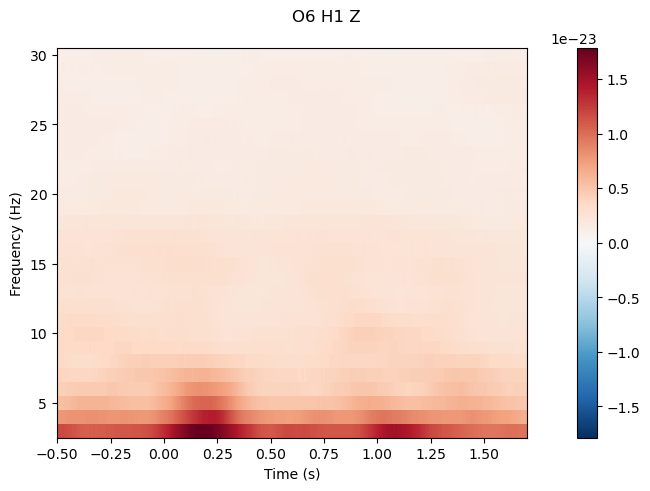

In [6]:
%matplotlib inline
sensor = 'O6 H1 Z'
tfr_slowL.plot(
    picks=sensor,
    #mode="percent", 
    tmin=-0.5, tmax=1.7, 
    title=sensor);  

Note the presence of the 10–12 Hz alpha band activity in the interval prior to the onset of the gratings. Also observe the power increase around ~0.2 s at 1–5 Hz, which likely reflects contributions from the event-related field (ERF).

To better observe these effects, one can apply a relative baseline correction. We have chosen `mode="percent"`, which performs a normalization with respect to the power in the baseline period:
As the sliding time-window is ΔT = 500 ms, we chose a baseline ranging from -500 to -250 ms.  
This ensures that the baseline does not overlap with the power values for *t > 0 ms*.


Applying baseline correction (mode: percent)


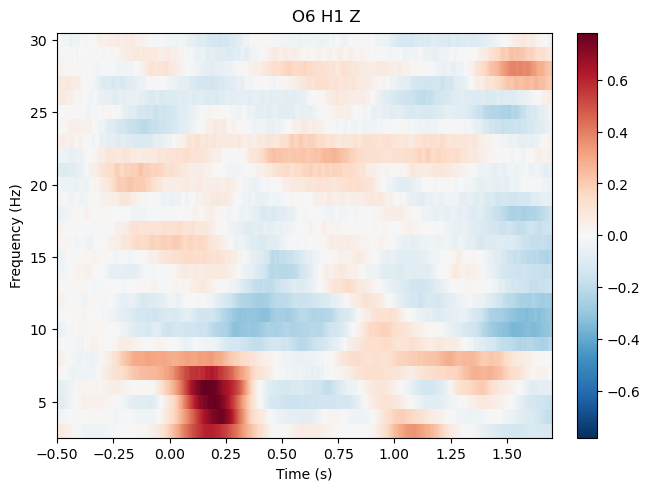

[<Figure size 640x480 with 2 Axes>]

In [7]:
sensor = 'O6 H1 Z'
tfr_slowL.plot(
    picks=sensor, 
    baseline=[-0.50,-0.25], 
    mode="percent", 
    tmin=-0.5, tmax=1.7,
    title=sensor)  

The figure above illustrates the modulation of power in response to visual stimulation. Note the typical power decrease after stimulus onset in the 10–12 Hz alpha band, and also a power decrease around ~20 Hz in the beta band. These effects reflect a suppression of ongoing oscillatory activity induced by visual input.

The early increase at ~5 Hz in the theta-band likely reflects the spectral signature of the event-related fields (ERFs), i.e., it does not reflect true oscillatory modulation**, but rather the broadband nature of evoked transients.


**Question 1:** Plot the results using an *absolute baseline*.  Why is a *relative baseline* typically used in group studies?


**To show the modulation in power for all sensors arranged topographically**, write

Applying baseline correction (mode: percent)


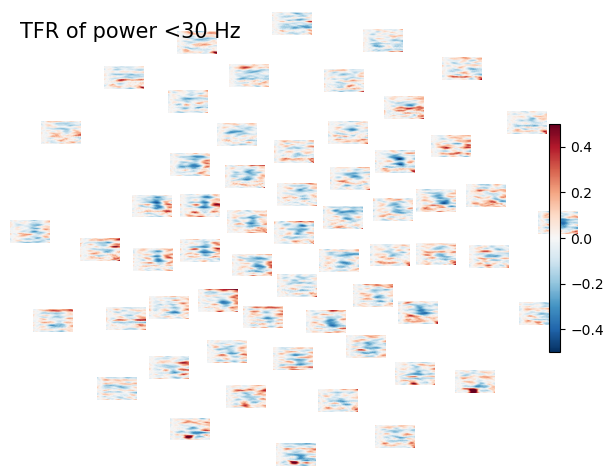

In [8]:
plt = tfr_slowL.plot_topo(
    tmin=-0.5, tmax=1.0, 
    baseline=[-0.5,-0.25], 
    mode="percent", 
    fig_facecolor='w',
    font_color='k',
    vmin=-0.5, vmax=0.5,
    title='TFR of power <30 Hz')

To show a topographic map of the alpha depression in the time interval from 250 to 750 ms use the plot_topomap command

Applying baseline correction (mode: percent)


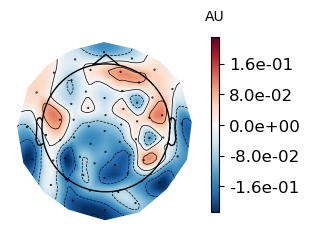

In [9]:
tfr_slowL.plot_topomap(
    tmin=0.25, tmax=0.75, 
    fmin=9, fmax=11,
    baseline=[-0.5,-0.25], 
    mode="percent",
    size=3
);

**@Prof. Ole**, please check Note the slight posterior right lateralization of the alpha suppression. This is most likely explained by allocation of attention to the right.

**Question 2**: Repeat the analysis with the 'attend left' trials. Are there any differences from the results of the 'attend left' trials?

**Question 3**: Change the time-window to 0.25 s and plot the results. What is the main effect in terms of time and frequency smoothing?

**Question 4**: Change the time-window to 1.00 s and plot the results. What is the main effect in terms of time and frequency smoothing?


## Comparing attend right versus attend left

The alpha activty in the cue-stimulus interval is known to be highly modulated by spatial attention. Specifically, numerous studies have demonstrated that posterior alpha power decrease in the hemisphere contralateral to attended direction whereas it increases relatively inthe ipsilateral hemisphere. To identify this effect we will illustrate the alpha modulation in the cue-stimulus interval (-0.5 to 0 s). This will be done by calculating the power lateralization index:

Note that this measures is calculated without performing baseline correction.

In [10]:
tfr_slow_diff = tfr_slowL.copy()
tfr_slow_diff.data = (tfr_slowR.data - tfr_slowL.data)/(tfr_slowR.data + tfr_slowL.data)

To show the power lateralization index for all sensors write:

No baseline correction applied


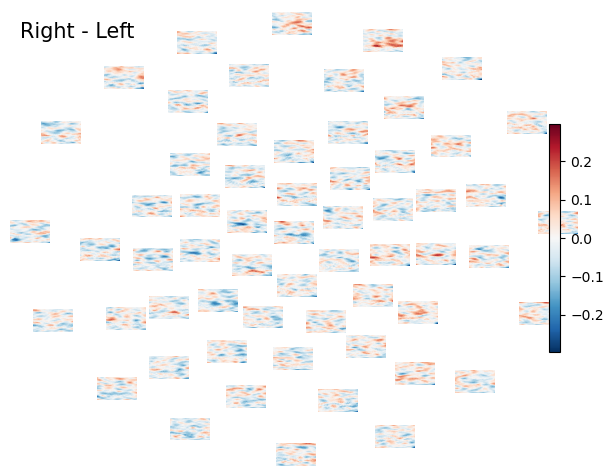

In [14]:
tfr_slow_diff.plot_topo(
    tmin=-0.5, tmax=1, 
    fig_facecolor='w',
    font_color='k',
    title='Right - Left');

To illustrate the lateralization index for the 10-12 Hz alpha band use the plot_topomap function:

No baseline correction applied


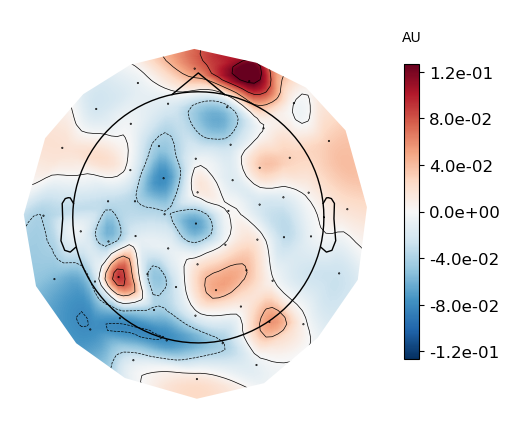

In [16]:
tfr_slow_diff.plot_topomap(tmin=0.25, tmax=0.75, fmin=10, fmax=12, size=5,show_names=False);


## Time-frequency analysis of faster frequencies (>30 hz)
To investigate spectral modulations at fast frequencies, more spectral smoothing is required. This can be achieved using the following settings:

- **freqs**:  
  Defines the frequency range for the analysis.  Use a range from 30 to 100 Hz, in steps of 2 Hz.

- **n_cycles**:  
  Set the number of cycles as:  
  n_cycles = freqs / 4  
  This results in a time window ΔT ≈ 250 ms, independent of frequency. The relatively short window ensures good temporal resolution.

- **time_bandwidth**:  
  Set time_bandwidth = 4.  
  This yields N = 3 tapers (since N = time_bandwidth - 1).  
  As N < 2 × ΔT × ΔF, the spectral smoothing is at least 6 Hz.  This level of smoothing is justified by the empirical observation that visual gamma-band activity is relatively broad-band.

For a detailed explanation of the multitaper method, see:  *Percival and Walden (1993), Spectral Analysis for Physical Applications*.


Apply these settings to both the left and right attention conditions (this step may be computationally intensive and time-consuming)



In [17]:
freqs = np.arange(31, 101, 2)
n_cycles = freqs / 4 
time_bandwidth = 4.0

tfr_fastL =  epochsL.compute_tfr(
    method = "multitaper",
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'mag',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=1,
    n_jobs = -1)

tfr_fastR =  epochsR.compute_tfr(
    method = "multitaper",
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'mag',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=1,
    n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   19.9s finished


Then plot the TFR for a posterior sensor and the left cue with respect to the gratings onset:

Applying baseline correction (mode: percent)


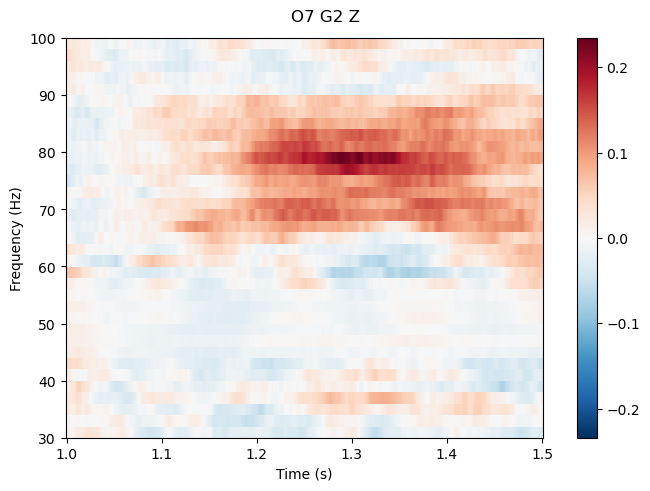

[<Figure size 640x480 with 2 Axes>]

In [19]:
%matplotlib inline
sensor = 'O7 G2 Z'
tfr_fastL.plot(
    picks=[sensor], 
    baseline=[1.0,1.1], 
    mode="percent", 
    tmin=1, tmax=1.5,
    title = sensor) 


Applying baseline correction (mode: percent)


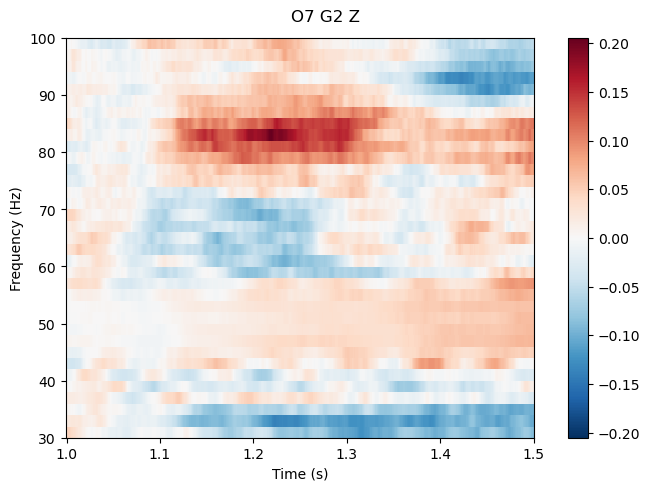

[<Figure size 640x480 with 2 Axes>]

In [20]:
%matplotlib inline
sensor = 'O7 G2 Z'
tfr_fastR.plot(
    picks=[sensor], 
    baseline=[1.0,1.1], 
    mode="percent", 
    tmin=1, tmax=1.5,
    title = sensor) 

Note the increase in 80-90 Hz gamma power in response to the onset (t = 0 s) of the gratings.

To show the TFRs for all sensors write:


Applying baseline correction (mode: percent)


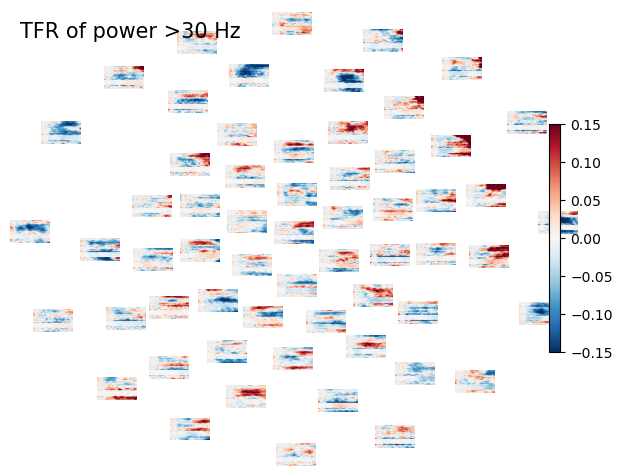

In [21]:
tfr_fastL.plot_topo(
    tmin=1, tmax=1.5, 
    baseline = [1,1.1], 
    mode="percent", 
    fig_facecolor='w',
    font_color='k',
    vmin=-0.15, vmax=0.15,
    title='TFR of power >30 Hz');

#### For the topographic representation for gamma activity in response to the gratings write:

Applying baseline correction (mode: percent)


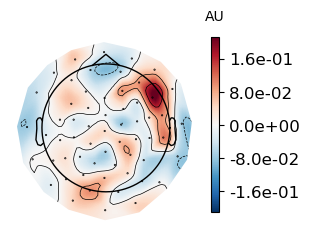

In [24]:
tfr_fastL.plot_topomap(
    tmin=1.3, tmax=1.5, 
    fmin=70, fmax=90, 
    baseline = [1,1.1], 
    mode="percent", 
    size=3
);



Here appreciate the posterior distribution of the gamma band activity.

Next, calculate the power lateralization index (using the same equations as for the lower frequencies).


In [25]:
tfr_fast_diff = tfr_fastL.copy()
tfr_fast_diff.data = (tfr_fastR.data - tfr_fastL.data)/(tfr_fastR.data + tfr_fastL.data)

Display all sensors

No baseline correction applied


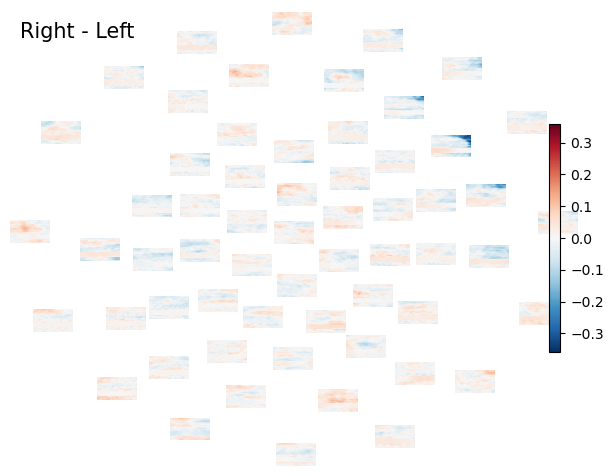

In [26]:
tfr_fast_diff.plot_topo(
    tmin=1.1, tmax=1.5, 
    fig_facecolor='w',
    font_color='k', 
    title='Right - Left');

as well as the topographic plots:

No baseline correction applied


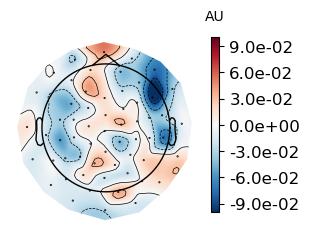

In [28]:
tfr_fast_diff.plot_topomap(
    tmin=1.3, tmax=1.5, 
    fmin=70, fmax=90,
    size = 3,
    vlim=(-0.1, 0.1)
);



**Question 5**: Compare the gamma lateralization to the alppha lateralization. Interpret the alpha and gamma band lateralization in relation to neuronal processing and functional inhibition.

**Question 6**: Change the smoothing to 20 Hz. How many tapers does this result in? What are the consequences for the time-frequency representation?


## Preregistration and publications

## References

- Tallon-Baudry, C., & Bertrand, O. (1999). Oscillatory gamma activity in humans and its role in object representation. *Trends in Cognitive Sciences, 3*(4), 151–162.

- Mitra, P., & Pesaran, B. (1999). Analysis of dynamic brain imaging data. *Biophysical Journal, 76*(2), 691–708.

- Percival, D. B., & Walden, A. T. (1993). *Spectral analysis for physical applications: Multitaper and conventional univariate techniques*. Cambridge University Press.


